## Modelowanie układów przepływowych - projekt
#### (budowa solwera równań płytkiej wody na bazie pakietu PyMPDATA)

### Kod solvera z ćwiczeń laboratoryjnych

In [79]:
!pip install --break-system pympdata

import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

import numpy as np
from matplotlib import pyplot as plt
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions
from scipy.ndimage import zoom
from mpl_toolkits.mplot3d import Axes3D

arrow_kwargs = {'length_includes_head': True, 'head_width': .05}

class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray,bathymetry:np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        self.bathymetry=bathymetry
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None) 
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[( 
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2 
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1): 
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

def plot(frame, *, zlim=(-0.25, 0.25)):
    psi = output['h'][frame]-bathymetry
    xi, yi = np.indices(psi.shape)
    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))
    ax.plot_wireframe(xi+.5, yi+.5, psi, color='blue', linewidth=.5)
    ax.set(zlim=zlim, proj_type='ortho', title=f"t / Δt = {frame}", zlabel=r"$\zeta$")
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)
    for axis in ('x', 'y'):
        getattr(ax, f'set_{axis}label')(f"{axis} / Δ{axis}")
    pyplot.colorbar(
        ax.contourf(xi+.5, yi+.5, bathymetry, zdir='z', offset=zlim[0]),
        pad=.1, aspect=10, fraction=.02, label='bathymetry', location='left'
    ).ax.invert_yaxis()
    return fig


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Batymetrie użyte w projekcie

W projekcie porównano trzy różne geometrie dna („mis z zupą”), które znacząco wpływają na rozchodzenie się i odbicia fal w równaniach płytkiej wody.

Wszystkie batymetrie są opisane funkcją wysokości dna  $b(x,y)$, a powierzchnia swobodna to  $\zeta(x,y,t) = h(x,y,t) - b(x,y)$.

Poniżej przedstawiono trzy rozpatrywane warianty.


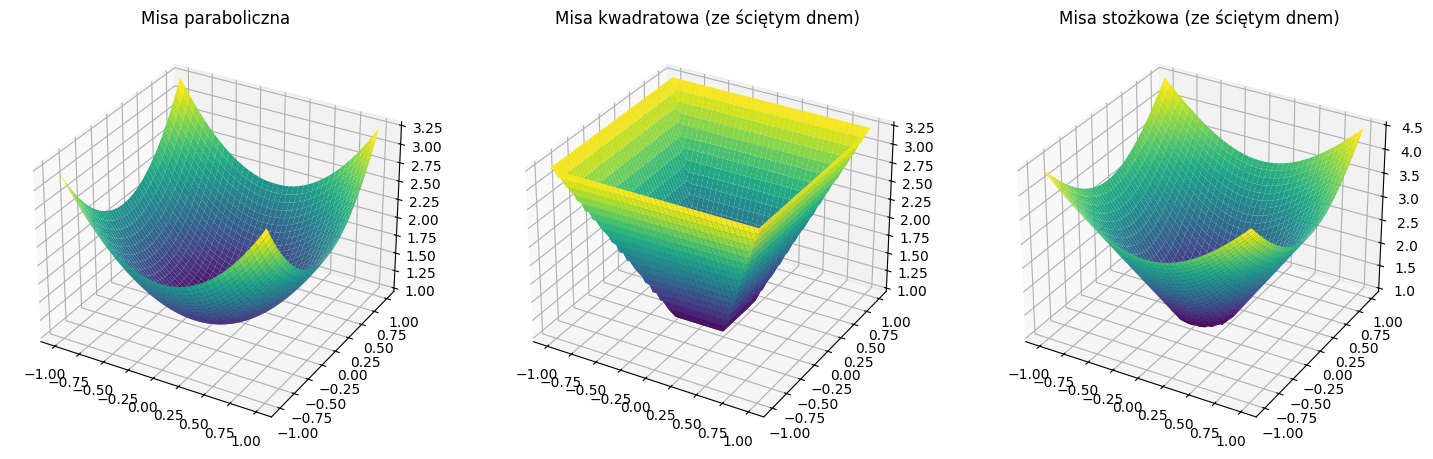

In [80]:
grid = (50, 40)
ny, nx = grid
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)


# 1) PARABOLICZNA MISA
# -------------------------
parabolic = X**2 + Y**2
parabolic = parabolic - parabolic.min()
parabolic = parabolic / parabolic.max()
parabolic = 1 + parabolic * 2.25


# KWADRATOWA MISA ze ściętym dnem
# -------------------------
floor_size_cells = 10
r0_cells = floor_size_cells/2
r0 = r0_cells * (2/nx)
H  = 2.25
sq_radius = np.maximum(np.abs(X), np.abs(Y))
sq = np.zeros_like(sq_radius)
sq[sq_radius <= r0] = 1.0

mask = sq_radius > r0
sq[mask] = 1.0 + ((sq_radius[mask] - r0) / (1 - r0)) * H


# 3) MISA STOŻKOWA ze ściętym dnem
# -------------------------
r = np.sqrt(X**2 + Y**2)
conical = np.zeros_like(r)
conical[r <= r0] = 1.0
mask2 = r > r0
conical[mask2] = 1.0 + ((r[mask2] - r0) / (1 - r0)) * H


# WYKRESY MIS
# -------------------------
fig = pyplot.figure(figsize=(18, 6))

# Paraboliczna
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, parabolic, cmap='viridis')
ax1.set_title("Misa paraboliczna")

# Kwadratowa (ze ściętym dnem)
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, sq, cmap='viridis')
ax2.set_title("Misa kwadratowa (ze ściętym dnem)")

# Stożkowa okrągła (ze ściętym dnem)
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, conical, cmap='viridis')
ax3.set_title("Misa stożkowa (ze ściętym dnem)")

pyplot.show()


### Funkcje wizualizacyjne

**`plot_velocity_multiple(...)`**  
Rysuje pole prędkości (wektory przepływu) nałożone na mapę zaburzenia powierzchni, dla kilku wybranych klatek symulacji.

**`plot_cross_sections_multiple(...)`**  
Pokazuje przekroje fali wzdłuż osi \(x\) i \(y\), co pozwala analizować kształt fali w środku domeny w kolejnych chwilach.

**`plot_surface_multiple(...)`**  
Wyświetla mapy 2D powierzchni swobodnej \(\zeta\) dla wielu klatek, umożliwiając porównanie globalnego rozkładu fal w czasie.


In [81]:
def plot_velocity_multiple(output, bathymetry, frames, step=3):

    n = len(frames)
    cols = 2
    rows = (n + 1) // 2

    fig, axes = pyplot.subplots(rows, cols, figsize=(13, 5*rows))
    axes = axes.flatten()

    for k, frame in enumerate(frames):
        ax = axes[k]

        h = output['h'][frame]
        uh = output['uh'][frame]
        vh = output['vh'][frame]

        # wysokość nad dnem
        zeta = h - bathymetry
        ny, nx = h.shape

        eps = 1e-8
        u = uh / (h + eps)
        v = vh / (h + eps)

        wet = zeta > 1e-6
        u = np.where(wet, u, 0)
        v = np.where(wet, v, 0)

        X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

        im = ax.contourf(X, Y, zeta, levels=30, cmap="viridis")
        fig.colorbar(im, ax=ax)

        vel = np.sqrt(u*u + v*v)
        vmax = np.quantile(vel, 0.99)  # 99 percentyl

        if vmax > 0:
            u2 = u / vmax
            v2 = v / vmax
        else:
            u2 = u
            v2 = v

        # rysujemy strzałki
        ax.quiver(
            X[::step, ::step],
            Y[::step, ::step],
            u2[::step, ::step],
            v2[::step, ::step],
            scale=15,
            color="black",
            width=0.002
        )

        ax.set_title(f"Pole prędkości — frame {frame}")
        ax.set_xlabel("x / Δx")
        ax.set_ylabel("y / Δy")

    pyplot.tight_layout()
    pyplot.show()


def plot_cross_sections_multiple(output, bathymetry, frames):
    n = len(frames)
    fig, axes = plt.subplots(n, 2, figsize=(10, 3*n))

    if n == 1:
        axes = np.array([axes])

    for i, frame in enumerate(frames):
        h = output["h"][frame]
        zeta = h - bathymetry

        ny, nx = zeta.shape
        mid_x = nx // 2
        mid_y = ny // 2

        # --- przekrój w x ---
        ax_v = axes[i, 0]
        ax_v.plot(zeta[:, mid_x])
        ax_v.set_title(f"Przekrój y — frame {frame}")
        ax_v.set_xlabel("y / Δy")
        ax_v.set_ylabel("ζ")

        # --- przekrój w y ---
        ax_h = axes[i, 1]
        ax_h.plot(zeta[mid_y, :])
        ax_h.set_title(f"Przekrój x — frame {frame}")
        ax_h.set_xlabel("x / Δx")
        ax_h.set_ylabel("ζ")

    plt.tight_layout()
    plt.show()

def plot_surface_multiple(output, bathymetry, frames):
    N = len(frames)
    cols = min(N, 3)
    rows = (N + 2) // 3

    plt.figure(figsize=(5*cols, 4*rows))

    for i, fr in enumerate(frames):
        h = output["h"][fr]
        zeta = h - bathymetry

        plt.subplot(rows, cols, i+1)
        plt.title(f"ζ — frame {fr}")
        plt.imshow(zeta, origin="lower", cmap="viridis")
        plt.colorbar(label="ζ")

    plt.tight_layout()
    plt.show()


### Wykonane symulacje

We wszystkich eksperymentach wykorzystano ten sam schemat:

**Model:** równania płytkiej wody z pełną nieliniowością.  
**Integrator:** klasa z ćwiczeń laboratoryjnych `ShallowWaterEquationsIntegrator` oparta na MPDATA  (z adwekcją `h`, `uh`, `vh` 
oraz źródłem grawitacyjnym $-g\nabla (h-b)$.

**Siatka:**  $50\times40$ komórek (w eksperymentach porównawczych także siatka podwojona).  
**Grawitacja:** $g = 10$.  
**Warunek początkowy:** lokalne podniesienie wysokości $h$ w centrum domeny o $+0.05$.  
**Warunki brzegowe:** zerowe przepływy (`Constant(0)` dla wszystkich pól).  
**Krok czasowy:** stabilny, z warunku Couranta,  $\frac{dt}{\Delta x} = \frac{dt}{\Delta y} = 0.18.$

We wszystkich przypadkach wyznaczano:
- ewolucję zaburzenia $\zeta = h-b$,
- pole prędkości $(u,v)$,
- przekroje powierzchni (pionowy i poziomy),
- 2D mapy wysokości powierzchni w wybranych chwilach.

Poniżej przedstawiono trzy symulacje z różną barymetrią (paraboliczną, kwadratową i stożkową),  
z tymi samymi parametrami fizycznymi i tym samym zaburzeniem początkowym.


### Symulacja: misa paraboliczna


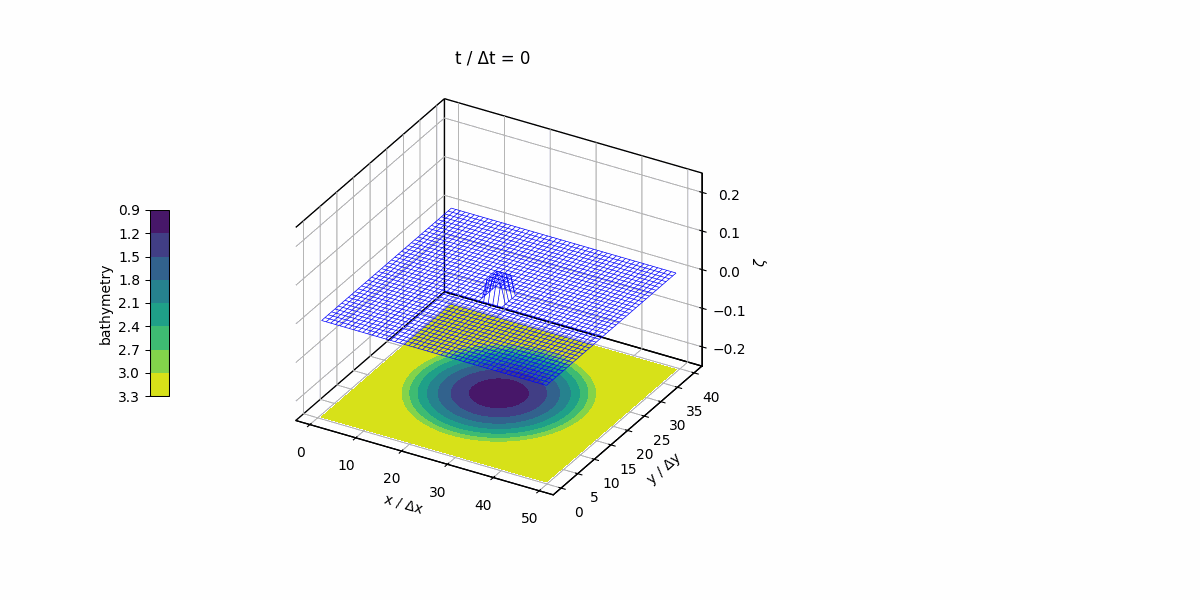

HTML(value="<a href='.\\tmpbeo8x6bl.gif' target='_blank'>.\\tmpbeo8x6bl.gif</a><br>")

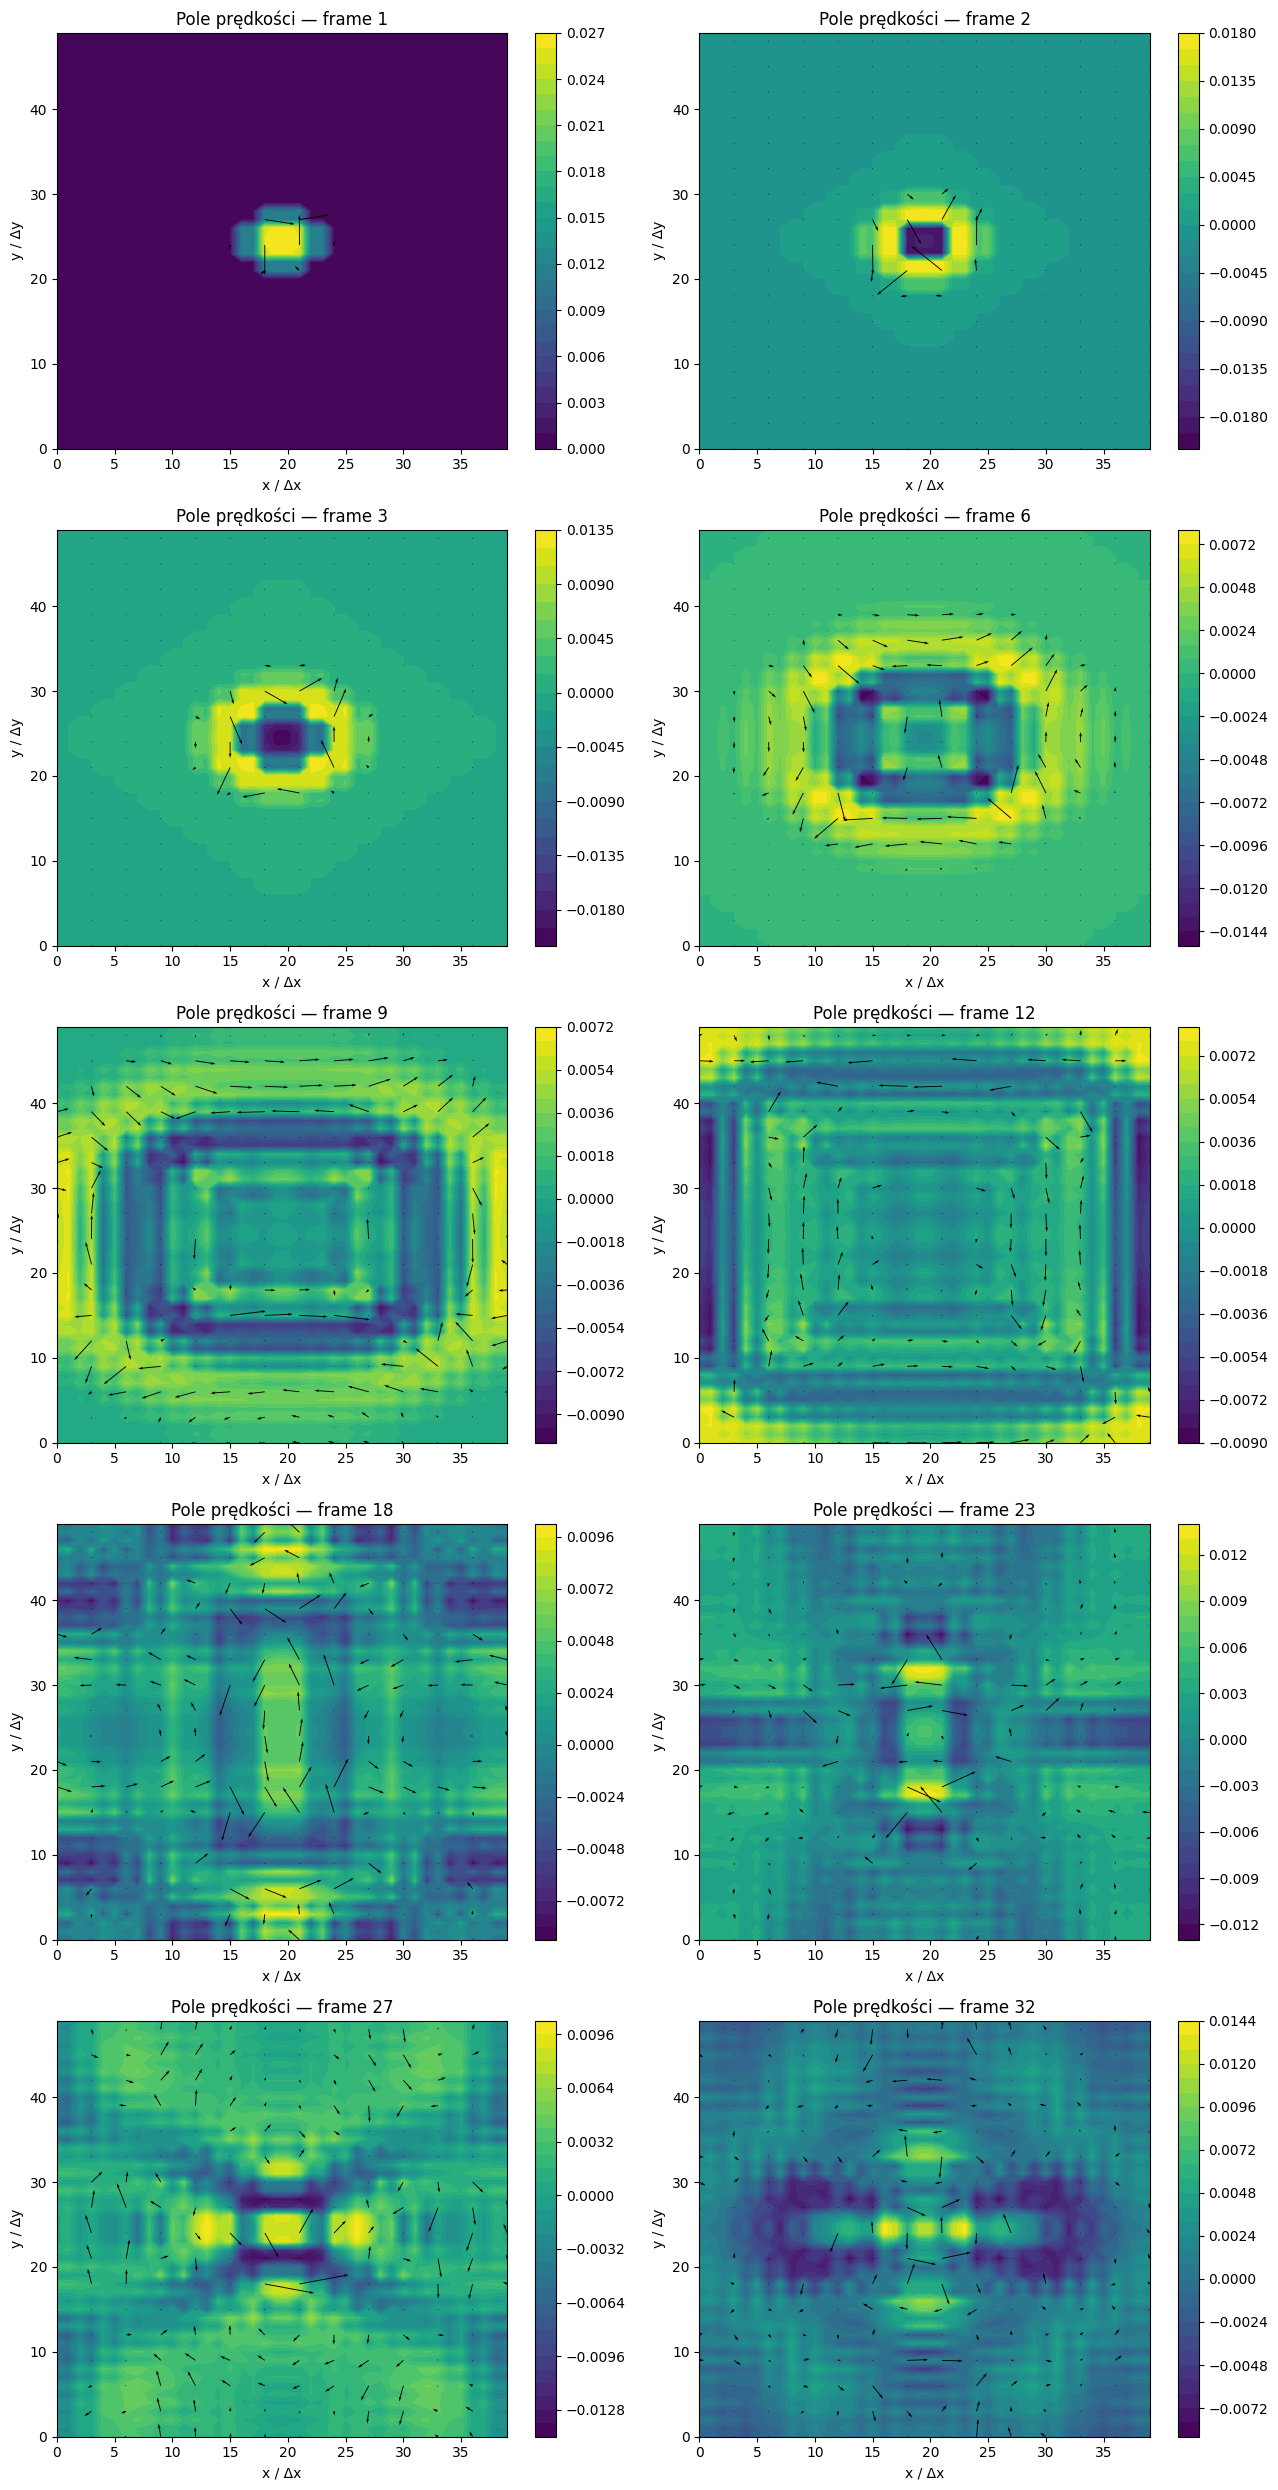

In [82]:
# 1) PARABOLICZNA MISA
# -------------------------

grid = (50, 40)
ny, nx = grid
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)
r = np.sqrt(X**2 + Y**2)

R = 0.8
H = 2.25

bathymetry = np.full_like(r, 1 + H)

inside = r <= R
bathymetry[inside] = 1 + H * (r[inside]**2 / R**2)

# -------- reszta jak było --------
h_initial = bathymetry.copy()
h_initial[
    grid[0] // 2 - grid[0] // 20:
    grid[0] // 2 + grid[0] // 20,
    grid[1] // 2 - grid[1] // 20:
    grid[1] // 2 + grid[1] // 20
] += .05

output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial,
    bathymetry=bathymetry
)(
    nt=100, g=10, dt_over_dxy=(.18, .18), outfreq=3
)

show_anim(plot, range(len(output['h'])))
plot_velocity_multiple(output, bathymetry, frames=[1, 2, 3, 6, 9, 12, 18, 23, 27, 32])


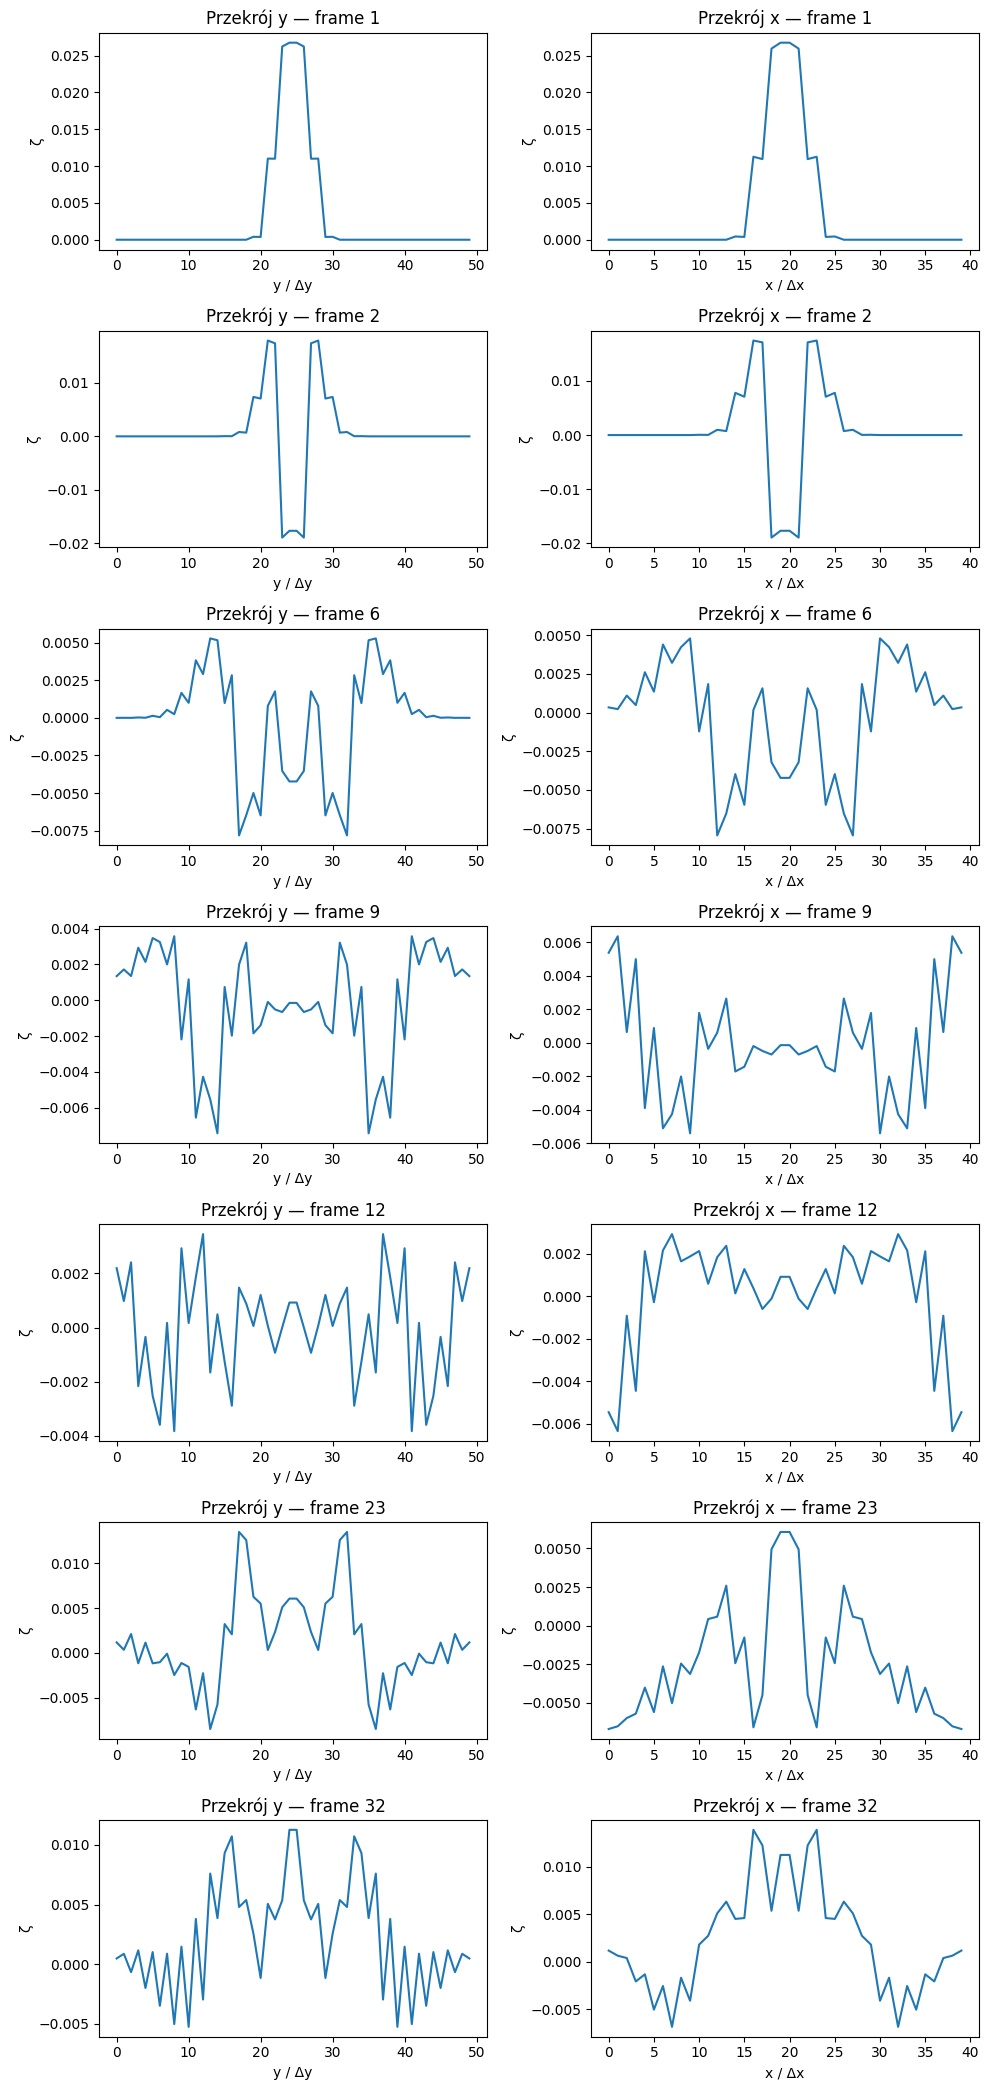

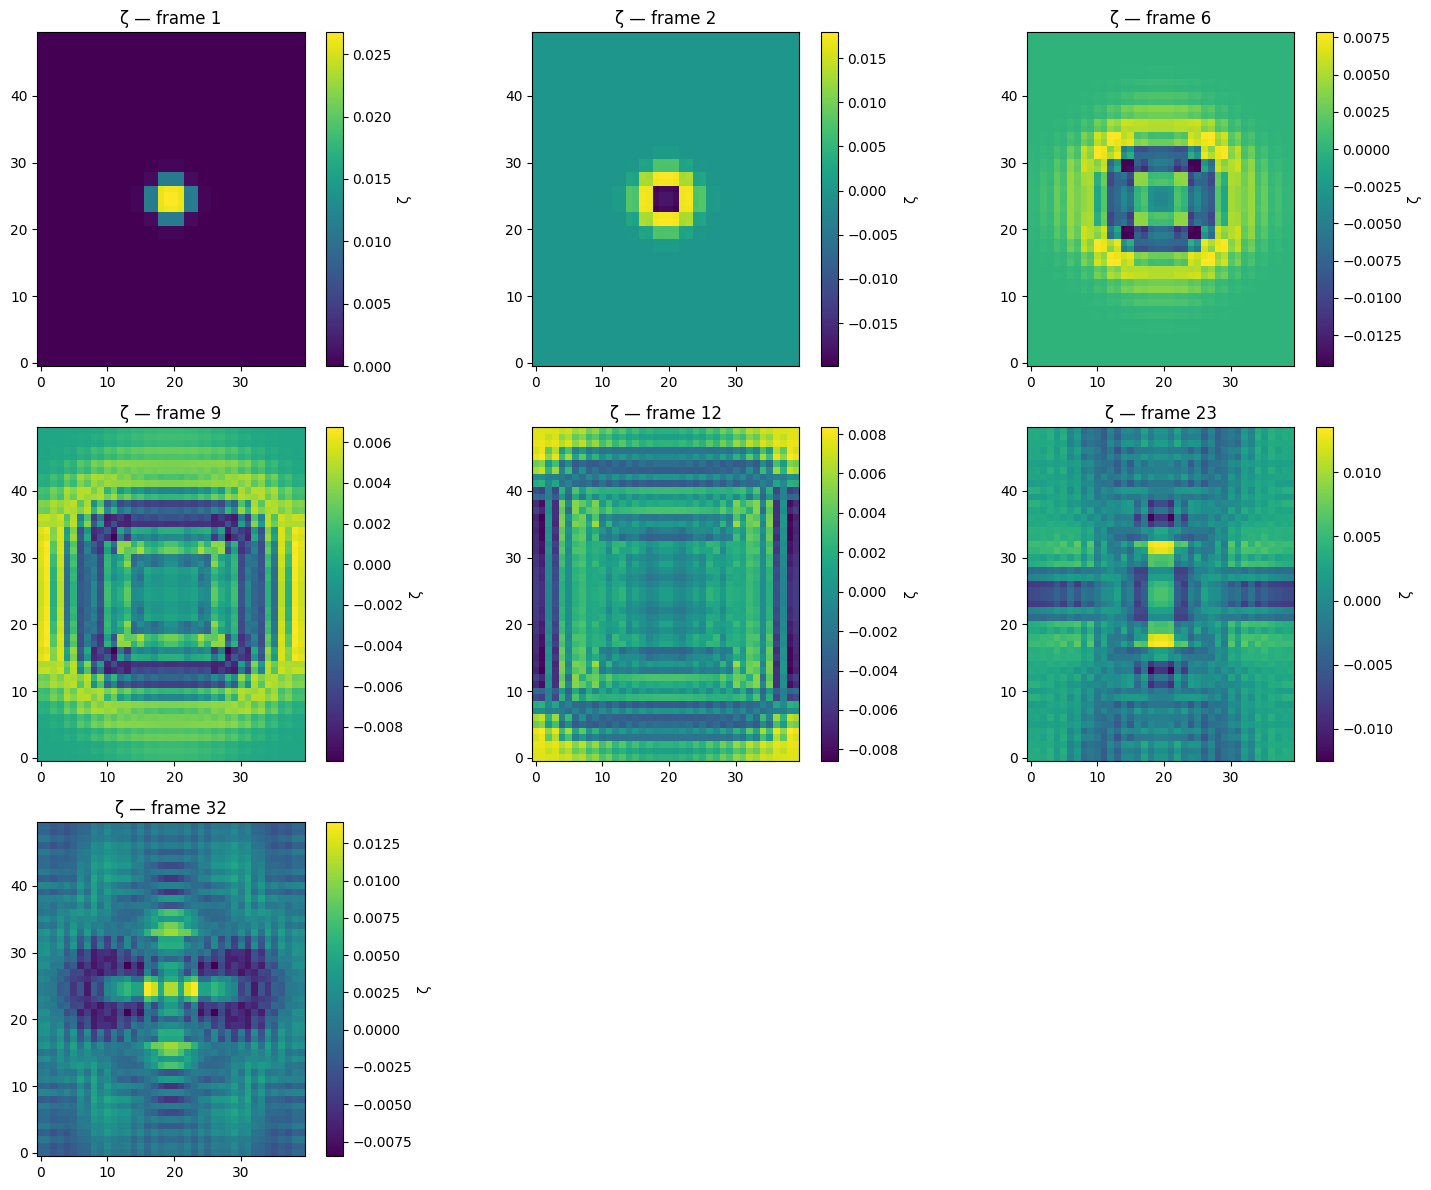

In [83]:
plot_cross_sections_multiple(output, bathymetry, frames=[1, 2, 6, 9, 12, 23, 32])
plot_surface_multiple(output, bathymetry, frames=[1, 2, 6, 9, 12, 23, 32])


## Interpretacja i Wyniki:
Fala rozchodzi się promieniście i odbija od okrągłego brzegu; dzięki gładkiej batymetrii propagacja jest regularna i bez silnych interferencji.
Przekroje wzdłuż osi $x$, $y$ pokazują ewolucję zaburzenia w misie o gładnym, izotropowym dnie.
Na wczesnych etapach fala zachowuje pełną symetrię osiową, zgodnie z promieniowym profilem batymetrii.
W miarę propagacji fala stopniowo ulega wygładzaniu i rozpraszaniu, a amplituda maleje z powodu szerokiego rozchodzenia się zaburzenia po paraboloidalnym zboczu.

### Symulacja: misa kwadratowa ze ściętym dnem


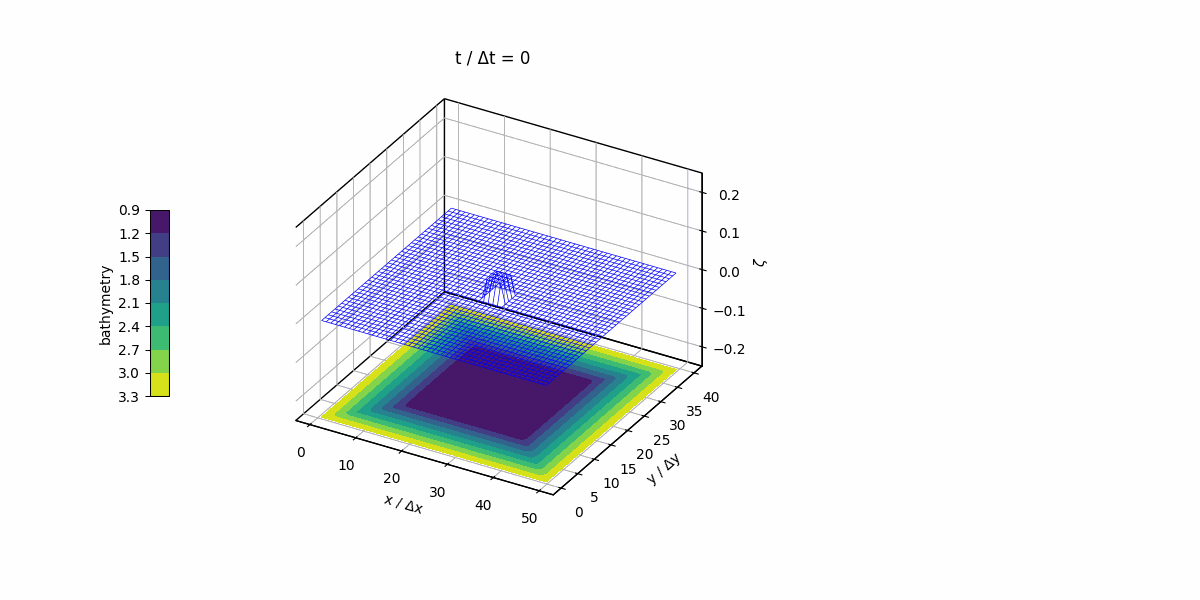

HTML(value="<a href='.\\tmp_gko3yre.gif' target='_blank'>.\\tmp_gko3yre.gif</a><br>")

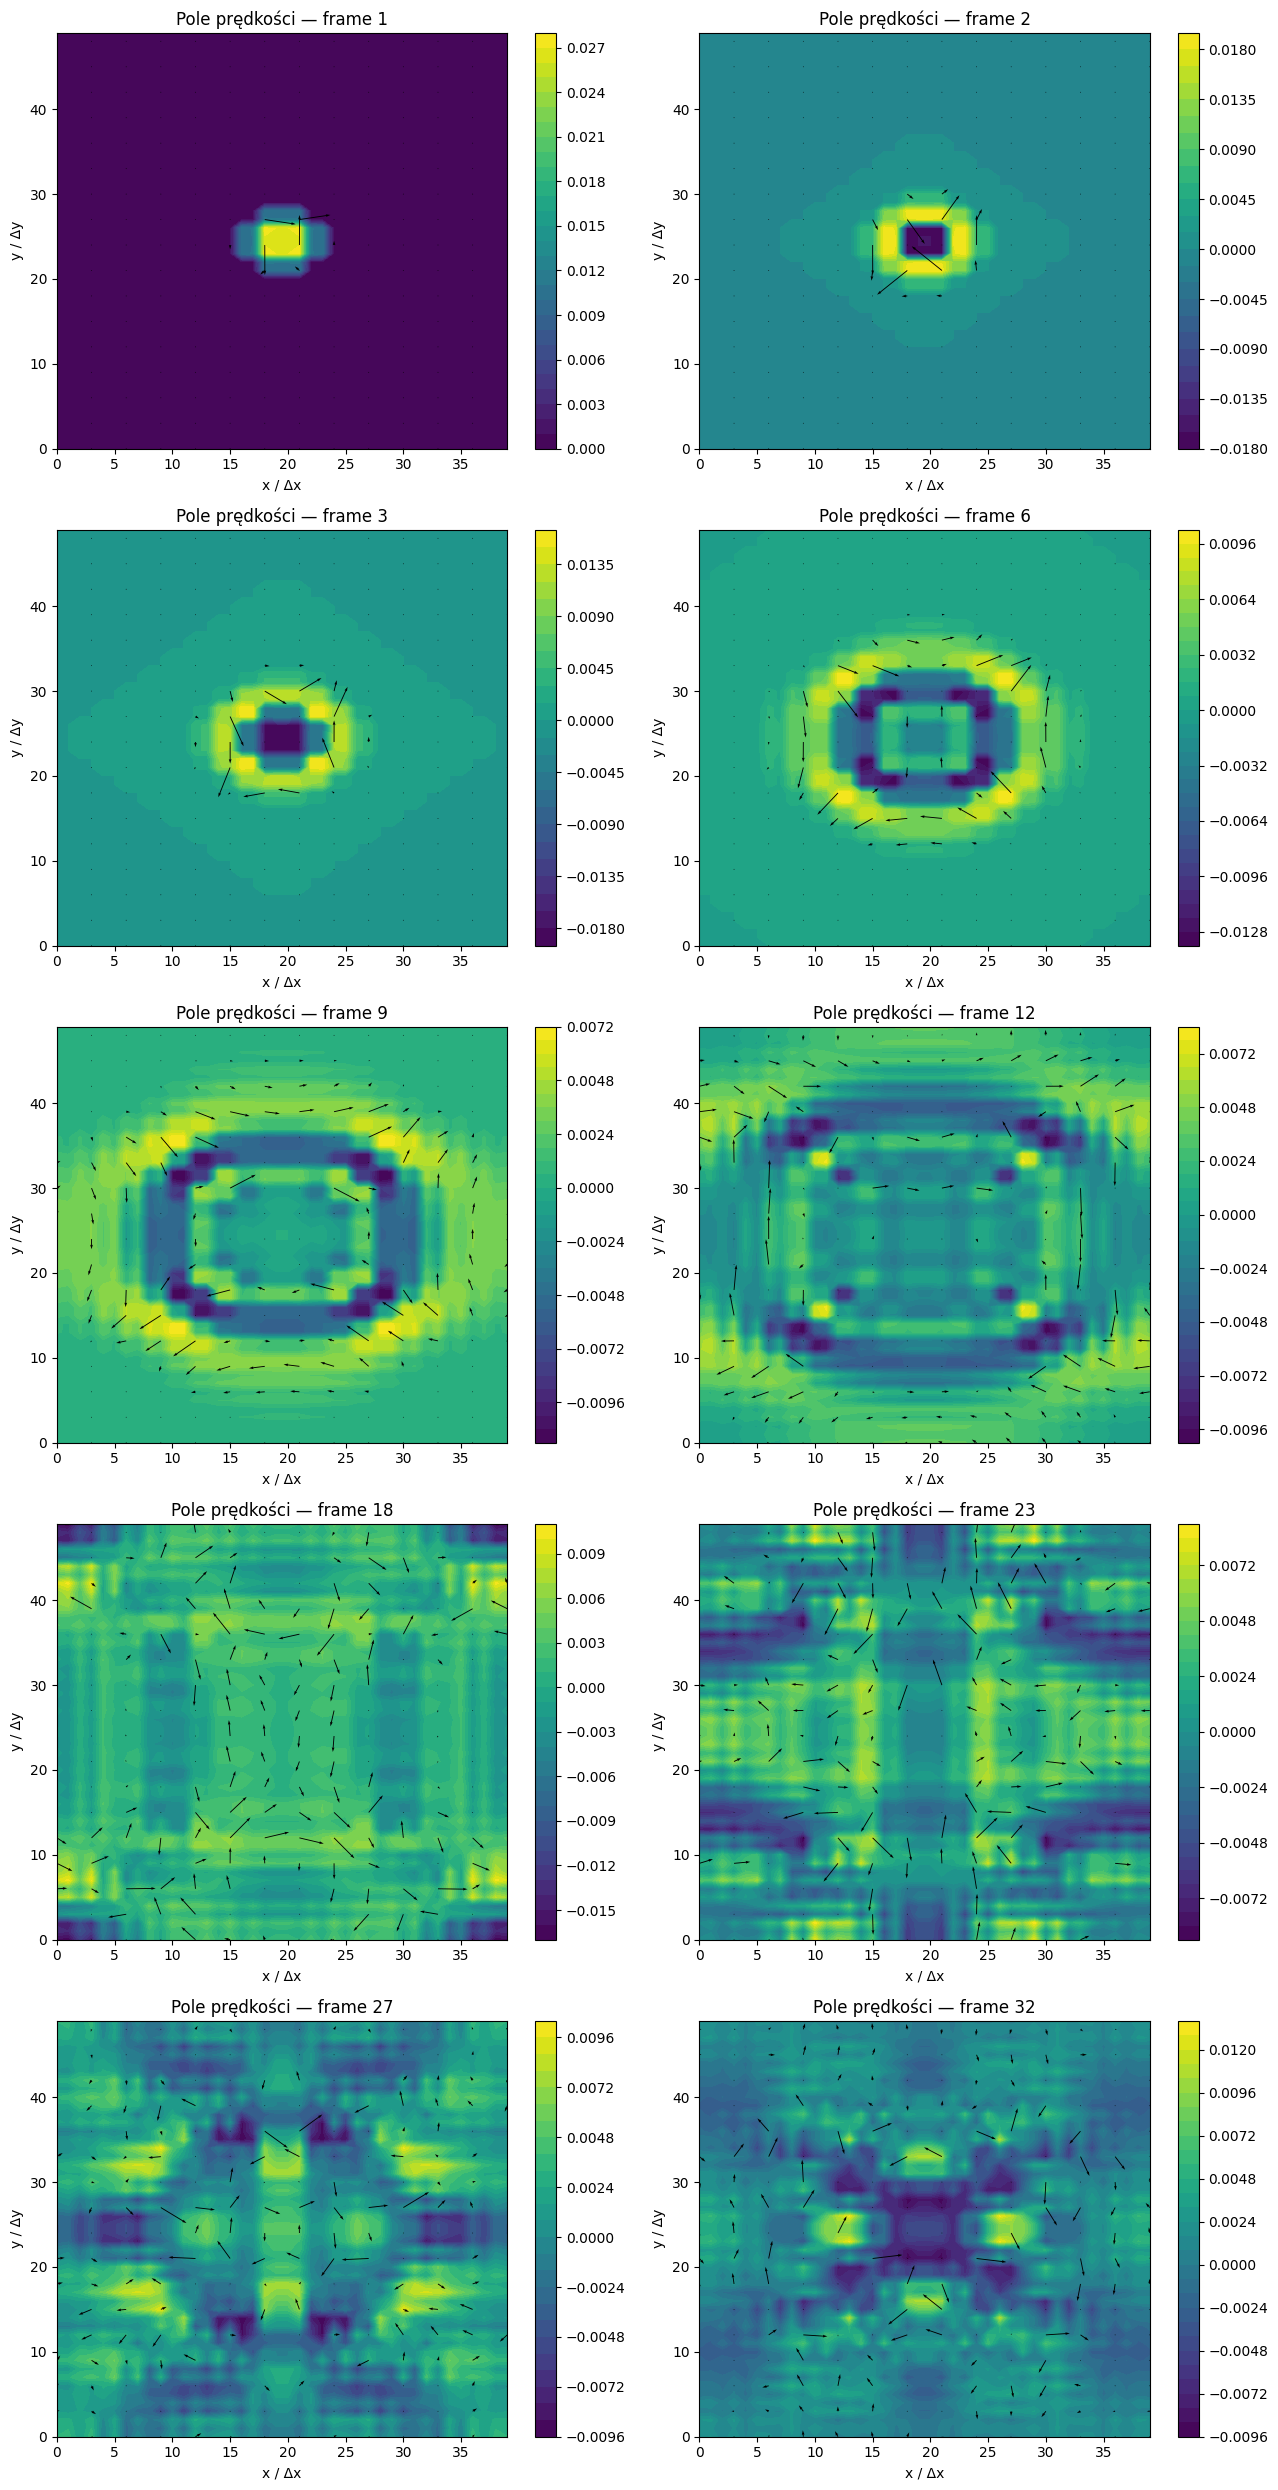

In [84]:
# KWADRATOWA MISA ze ściętym dnem
# -------------------------

grid = (50, 40)
ny, nx = grid
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

floor_size_cells = 10          
r0_cells = floor_size_cells/2  

r0 = r0_cells / (nx/2)
H  = 2.25

sq_radius = np.maximum(np.abs(X - 0.5), np.abs(Y - 0.5))
bathymetry = np.zeros_like(sq_radius)

bathymetry[sq_radius <= r0] = 1.0

mask = sq_radius > r0
bathymetry[mask] = 1.0 + ((sq_radius[mask] - r0) / (0.5 - r0)) * H

h_initial = bathymetry.copy()
h_initial[
    grid[0] // 2 - grid[0] // 20 : grid[0] // 2 + grid[0] // 20,
    grid[1] // 2 - grid[1] // 20 : grid[1] // 2 + grid[1] // 20
] += .05

output = ShallowWaterEquationsIntegrator(h_initial=h_initial,bathymetry=bathymetry)(
    nt=100, g=10, dt_over_dxy=(.18, .18), outfreq=3
)

show_anim(plot, range(len(output['h'])))
plot_velocity_multiple(output, bathymetry, frames=[1, 2, 3, 6, 9, 12, 18, 23, 27, 32])

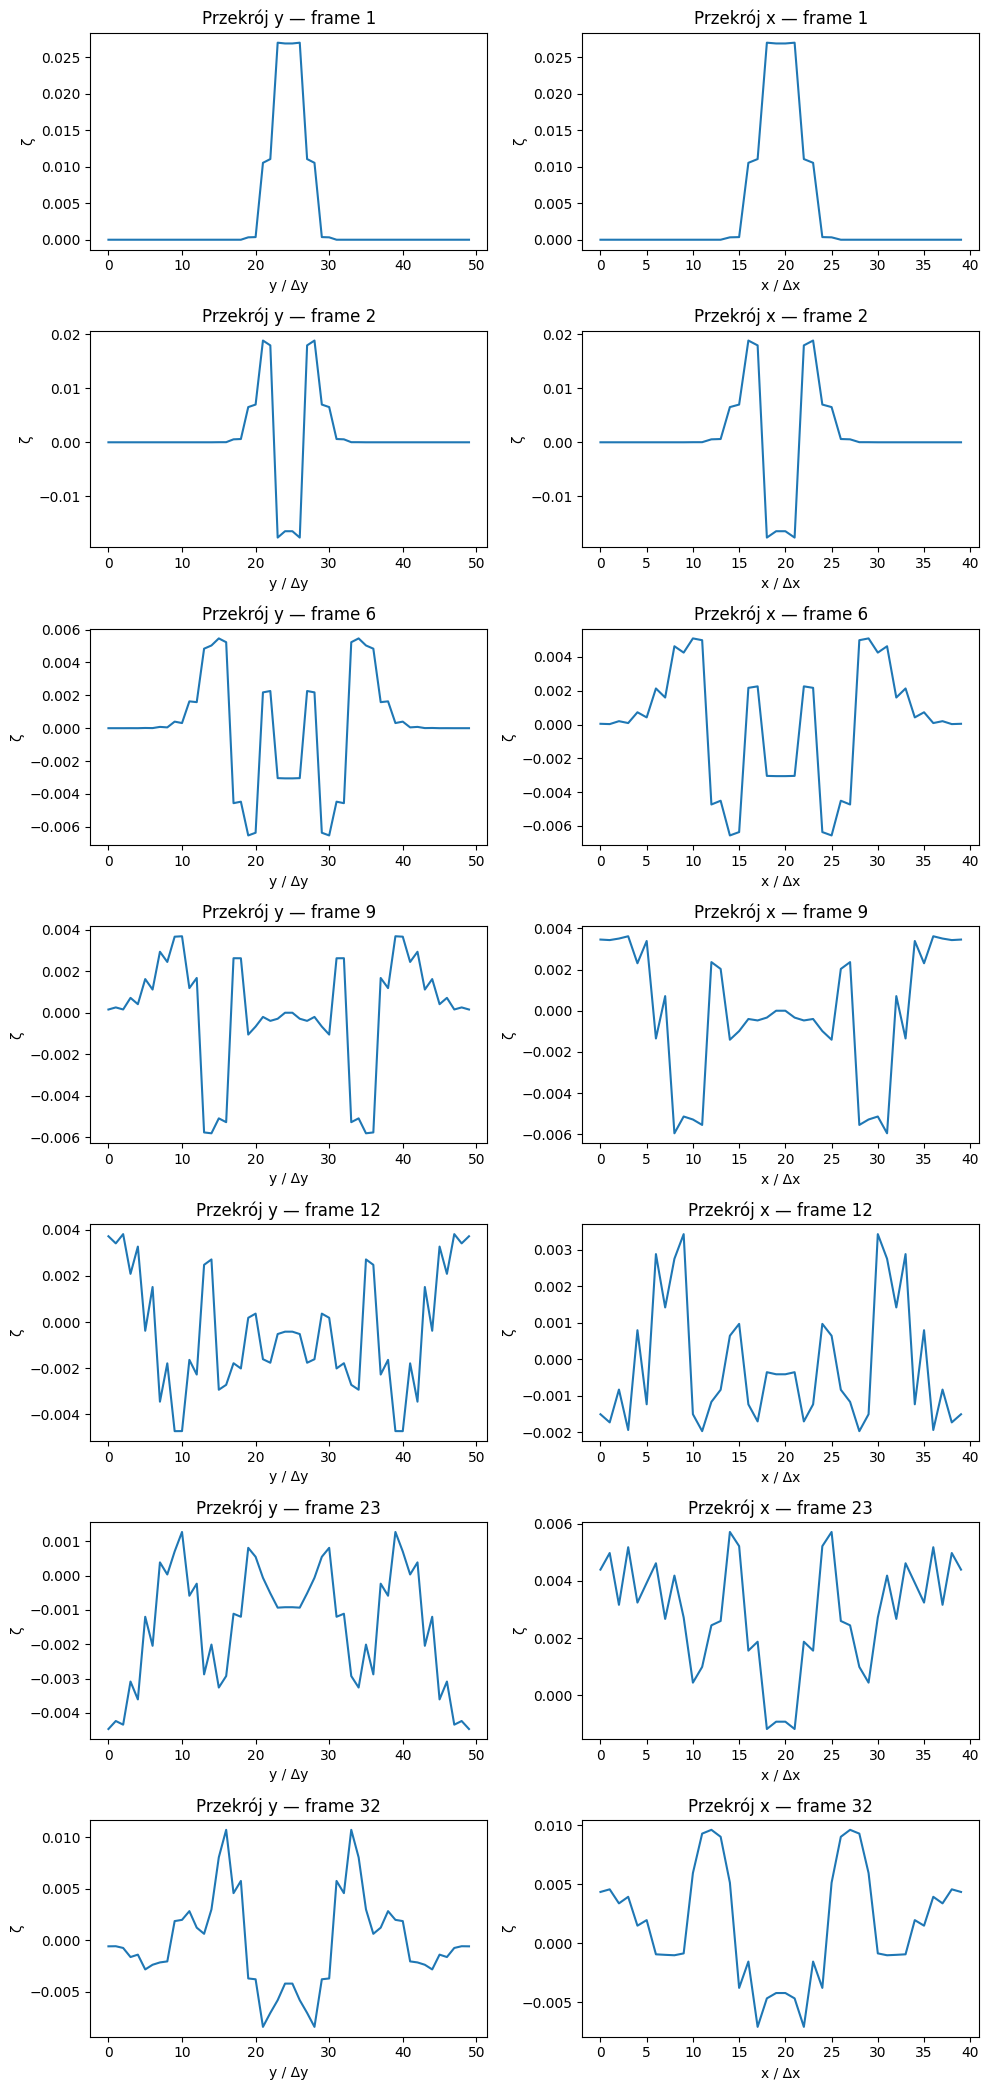

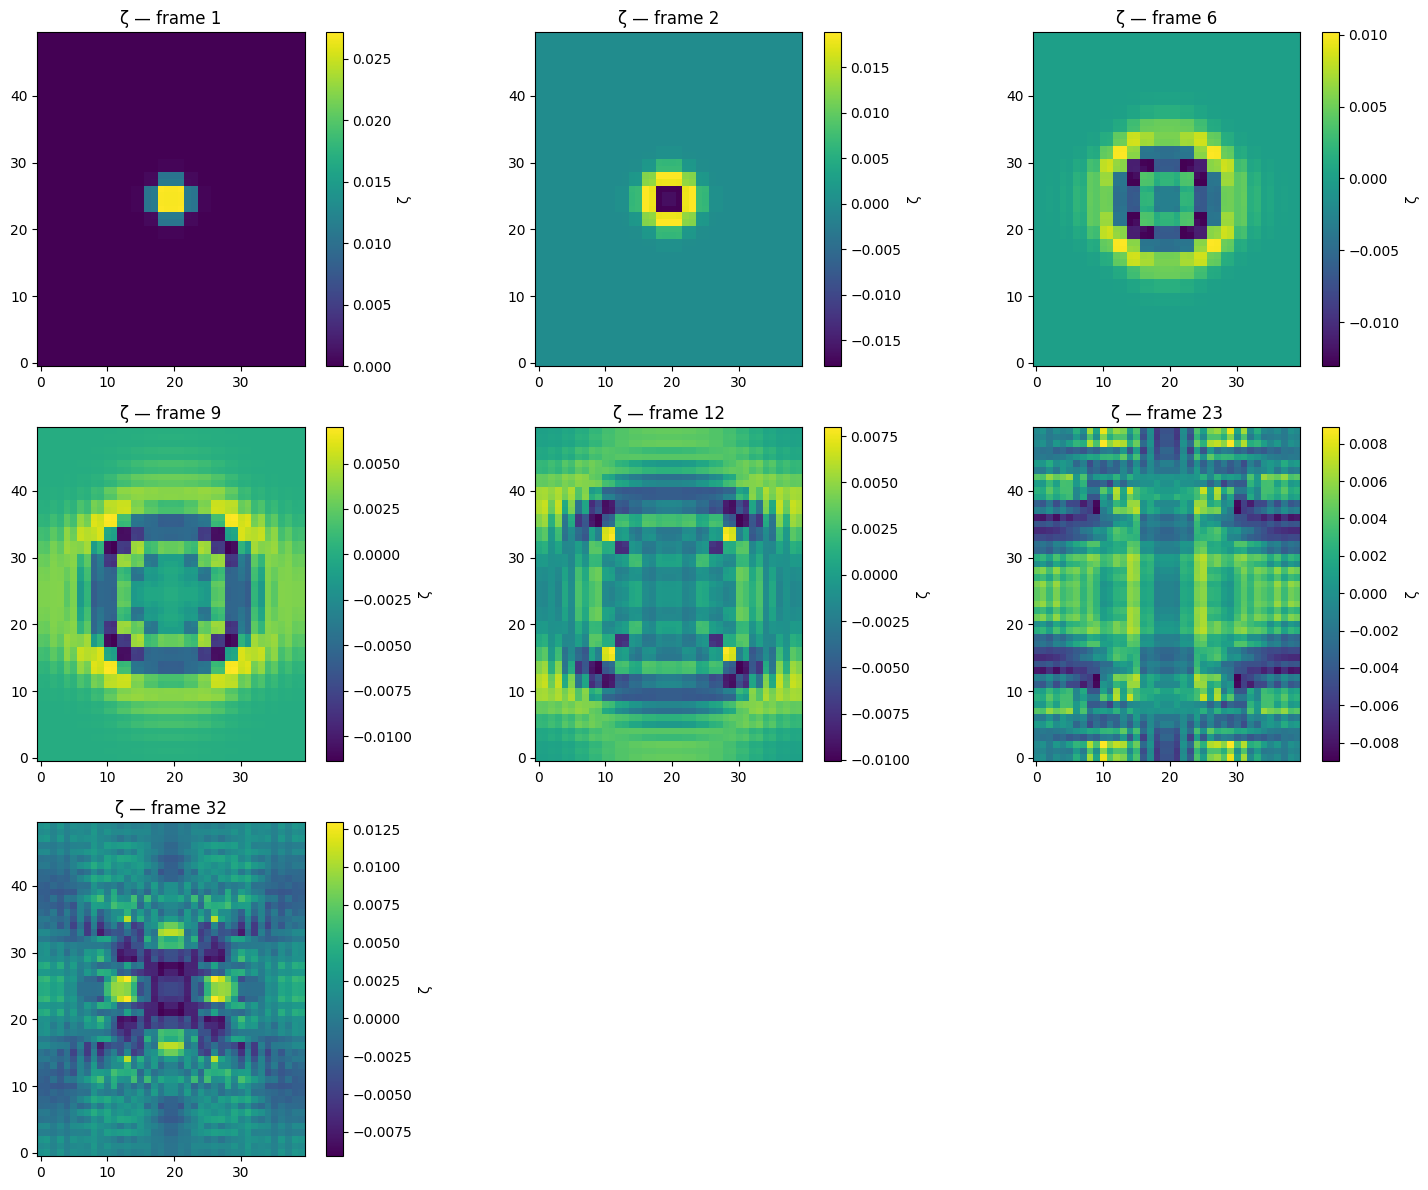

In [85]:
plot_cross_sections_multiple(output, bathymetry, frames=[1, 2, 6, 9, 12, 23, 32])
plot_surface_multiple(output, bathymetry, frames=[1, 2, 6, 9, 12, 23, 32])

## Interpretacja i Wyniki:
Fala rozchodzi się promieniście i odbija od okrągłego brzegu; dzięki gładkiej batymetrii propagacja jest regularna i bez silnych interferencji.
Przekroje wzdłuż osi $x$, $y$ pokazują ewolucję zaburzenia w misie o gładnym, izotropowym dnie.
Na wczesnych etapach fala zachowuje pełną symetrię osiową, zgodnie z promieniowym profilem batymetrii.
W miarę propagacji fala stopniowo ulega wygładzaniu i rozpraszaniu, a amplituda maleje z powodu szerokiego rozchodzenia się zaburzenia po paraboloidalnym zboczu.


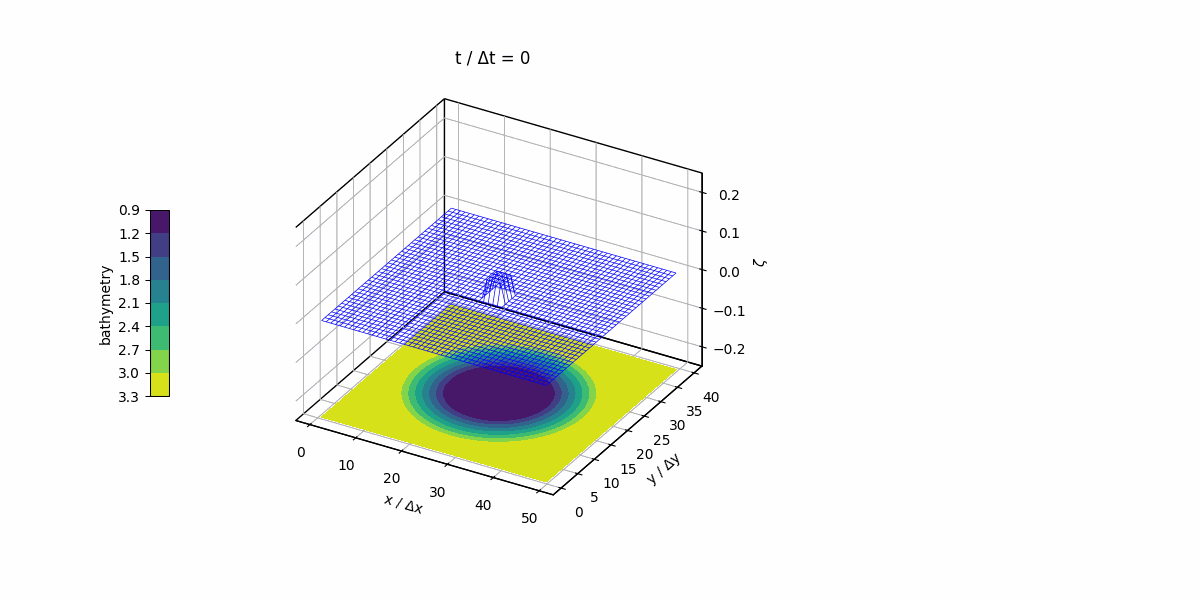

HTML(value="<a href='.\\tmpj8f3accr.gif' target='_blank'>.\\tmpj8f3accr.gif</a><br>")

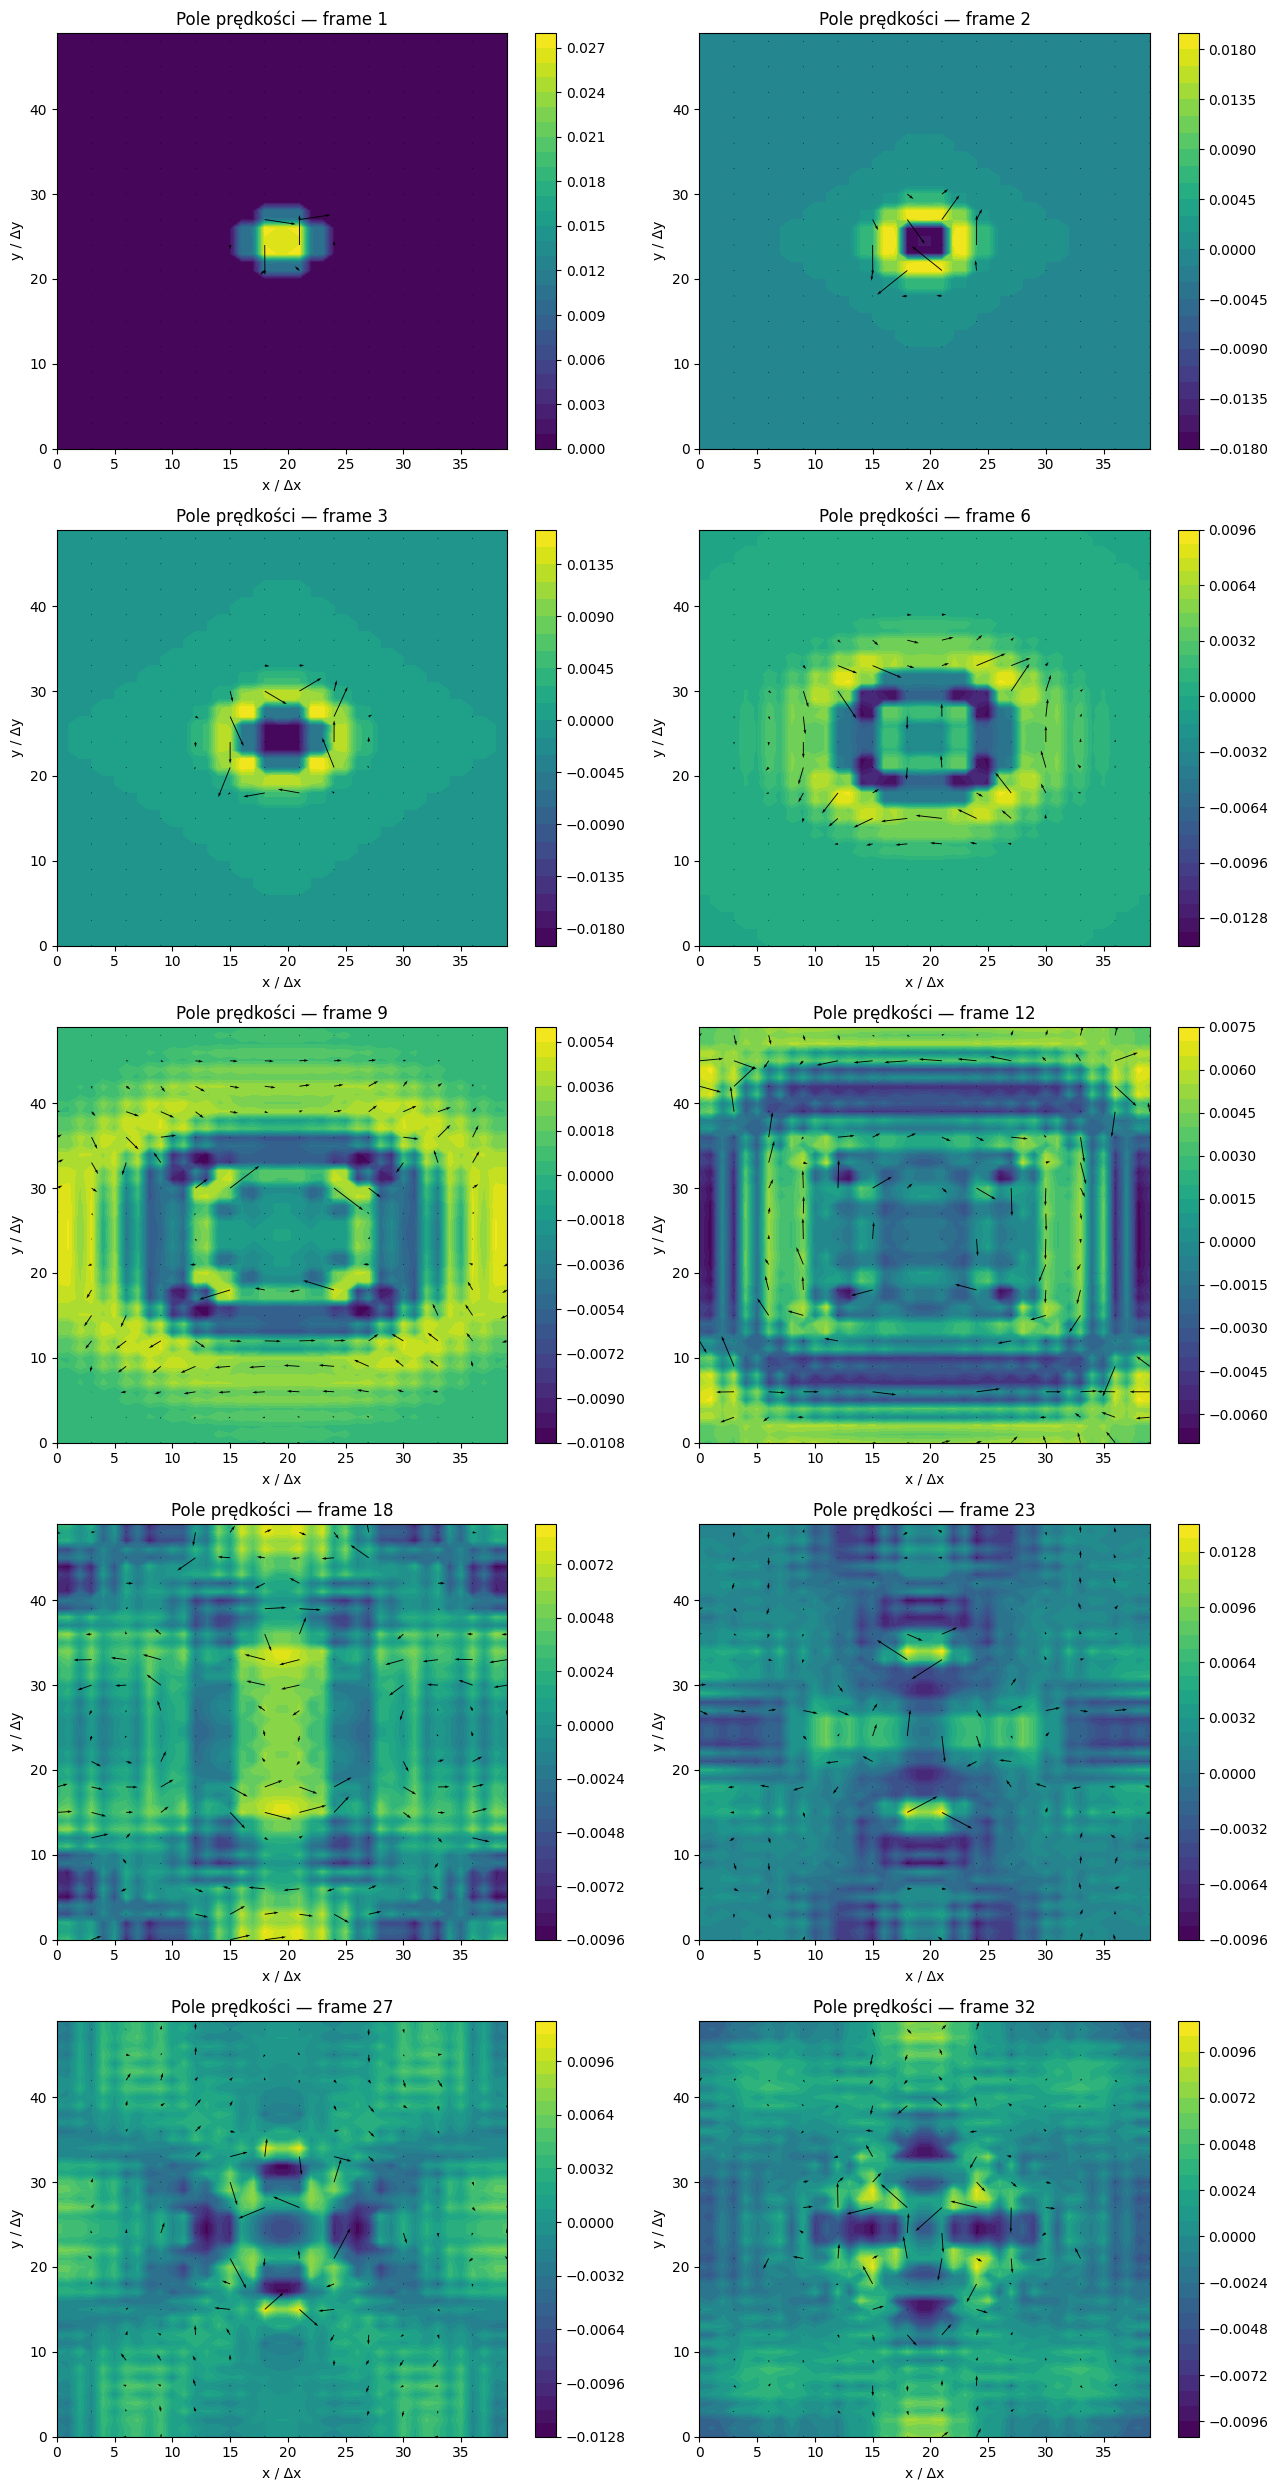

In [86]:
# 3) MISA STOŻKOWA ZE ŚCIĘTYM DNEM — OKRĄGŁY BRZEG
# ------------------------------------------------

ny, nx = grid
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)

r = np.sqrt(X**2 + Y**2)

r0 = 0.4
R  = 0.8
H  = 2.25

bathymetry = np.full_like(r, 1 + H)

inside_flat = r <= r0
bathymetry[inside_flat] = 1.0

cone = (r > r0) & (r <= R)
bathymetry[cone] = 1.0 + H * (r[cone] - r0) / (R - r0)

h_initial = bathymetry.copy()
h_initial[
    grid[0] // 2 - grid[0] // 20 :
    grid[0] // 2 + grid[0] // 20,
    grid[1] // 2 - grid[1] // 20 :
    grid[1] // 2 + grid[1] // 20
] += 0.05

output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial,
    bathymetry=bathymetry
)(
    nt=100, g=10, dt_over_dxy=(0.18, 0.18), outfreq=3
)

show_anim(plot, range(len(output['h'])))
plot_velocity_multiple(output, bathymetry,
                       frames=[1,2,3,6,9,12,18,23,27,32])


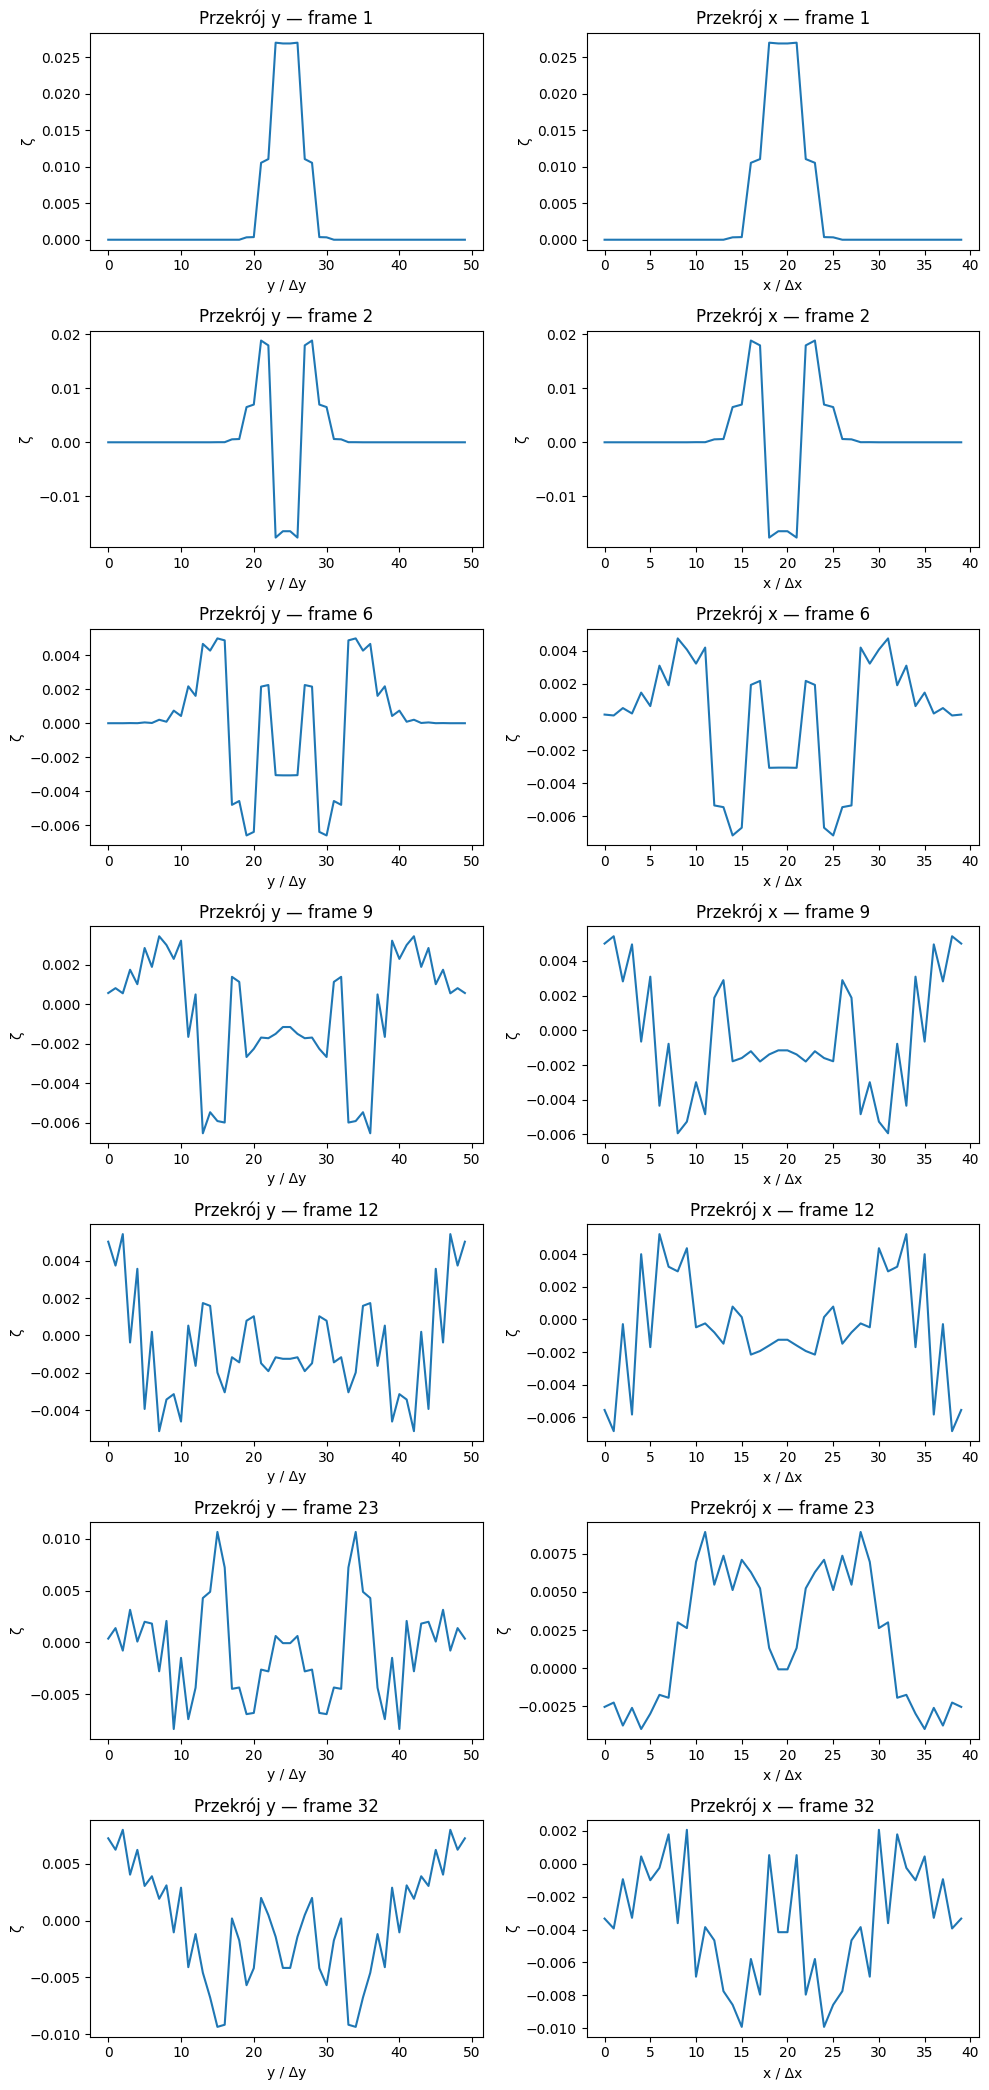

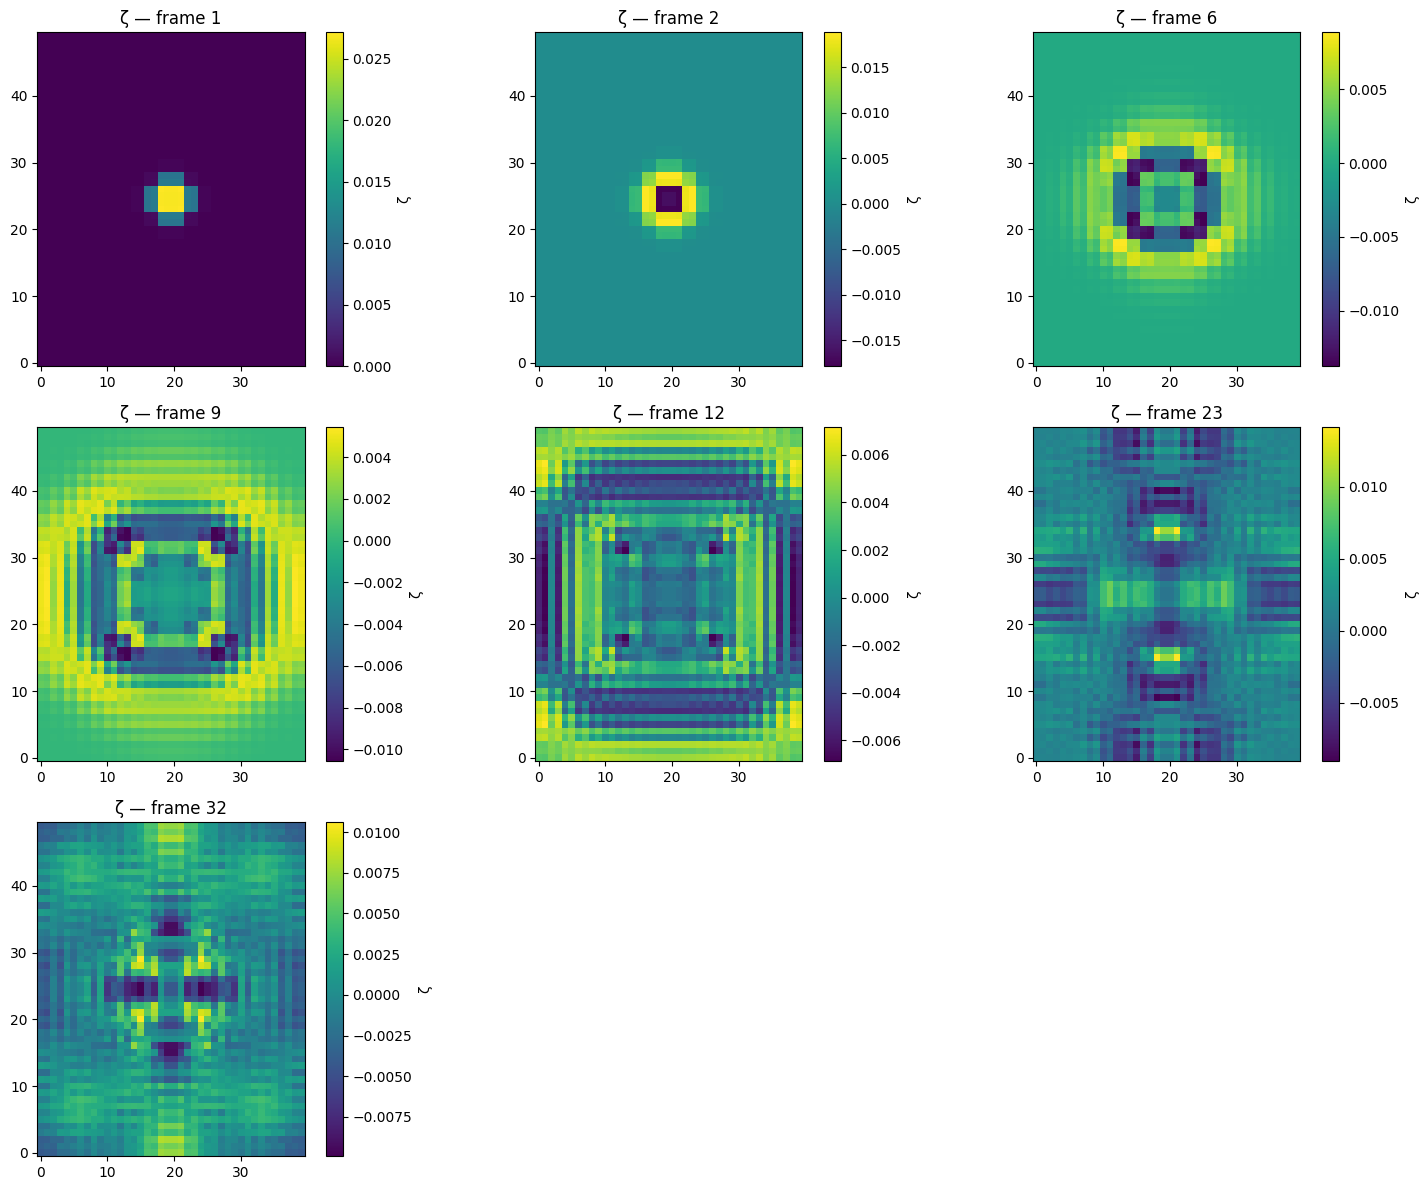

In [87]:
plot_cross_sections_multiple(output, bathymetry, frames=[1, 2, 6, 9, 12, 23, 32])
plot_surface_multiple(output, bathymetry, frames=[1, 2, 6, 9, 12, 23, 32])


Fala początkowo rozchodzi się osiowo, lecz po dotarciu do liniowo rosnących ścian stożkowych ulega silnemu odbiciu i skupianiu energii w kierunku środka misy. Charakterystyczne są wyraźne interferencje wynikające z kombinacji: płaskiego dna, stromej ściany oraz okrągłego brzegu. Przekroje wzdłuż osi $x$ i $y$  pokazują serię kolejnych ogniskowań i rozprężeń fali — amplituda lokalnie rośnie przy powrotach w stronę centrum, a sygnał staje się coraz bardziej nieregularny wskutek wielokrotnych odbić od stożkowych ścian. W porównaniu z misą paraboliczną propagacja jest mniej regularna (amplituda fali odbitej jest mniejsza).

In [88]:
# PODWOJONA ROZDZIELCZOŚĆ PRZESTRZENNA I CZASOWA - MISA STOŻKOWA
# --------------------------------------------------------

r0 = 0.4
R  = 0.8
H  = 2.25

grid2 = (grid[0] * 2, grid[1] * 2)
ny2, nx2 = grid2

# Nowe współrzędne
x2 = np.linspace(-1, 1, nx2)
y2 = np.linspace(-1, 1, ny2)
X2, Y2 = np.meshgrid(x2, y2)

r2 = np.sqrt(X2**2 + Y2**2)

bathymetry2 = np.full_like(r2, 1 + H)
inside_flat2 = r2 <= r0
bathymetry2[inside_flat2] = 1.0

cone2 = (r2 > r0) & (r2 <= R)
bathymetry2[cone2] = 1.0 + H * (r2[cone2] - r0) / (R - r0)
h_initial2 = bathymetry2.copy()

imp2 = ny2 // 20

h_initial2[
    ny2//2 - imp2 : ny2//2 + imp2,
    nx2//2 - imp2 : nx2//2 + imp2
] += 0.05

dt2 = (0.18 / 2, 0.18 / 2)

output2 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial2,
    bathymetry=bathymetry2
)(
    nt=200, g=10, dt_over_dxy=dt2, outfreq=6
)


=== BŁĘDY ZBIEŻNOŚCI ===
L∞ = 0.014111
L2 = 0.004689


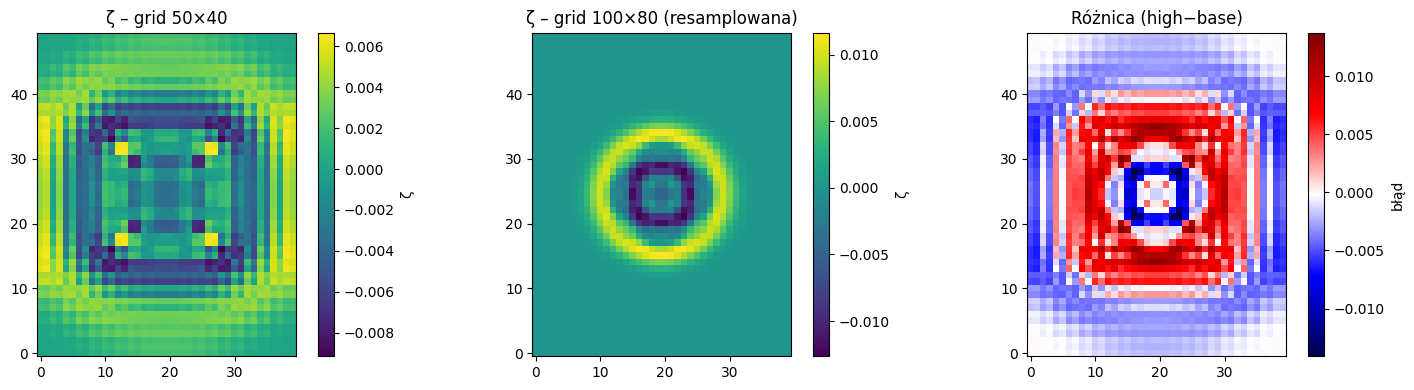

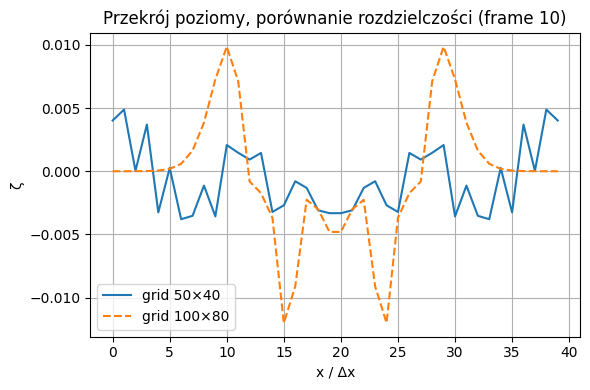

In [89]:
frame = 10

zeta1 = output["h"][frame] - bathymetry
zeta2 = output2["h"][frame] - bathymetry2

zeta2_resampled = zoom(zeta2, 0.5, order=1)

error = zeta2_resampled - zeta1

Linf = np.max(np.abs(error))
L2   = np.sqrt(np.mean(error**2))

print("=== BŁĘDY ZBIEŻNOŚCI ===")
print(f"L∞ = {Linf:.6f}")
print(f"L2 = {L2:.6f}")

ny, nx = zeta1.shape
mid_y = ny // 2

sec1 = zeta1[mid_y, :]
sec2 = zeta2_resampled[mid_y, :]

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.title("ζ – grid 50×40")
plt.imshow(zeta1, origin="lower", cmap="viridis")
plt.colorbar(label="ζ")

plt.subplot(1,3,2)
plt.title("ζ – grid 100×80 (resamplowana)")
plt.imshow(zeta2_resampled, origin="lower", cmap="viridis")
plt.colorbar(label="ζ")

plt.subplot(1,3,3)
plt.title("Różnica (high−base)")
plt.imshow(error, origin="lower", cmap="seismic")
plt.colorbar(label="błąd")

plt.tight_layout()
plt.show()


frames = range(len(output["h"]))  # wszystkie zapisane klatki
L2_list = []
Linf_list = []

for fr in frames:
    z1 = output["h"][fr]  - bathymetry
    z2 = output2["h"][fr] - bathymetry2
    z2r = zoom(z2, 0.5, order=1)

    err = z2r - z1
    L2_list.append(np.sqrt(np.mean(err**2)))
    Linf_list.append(np.max(np.abs(err)))

ny, nx = zeta1.shape
mid_y = ny // 2

sec1 = zeta1[mid_y, :]
sec2 = zeta2_resampled[mid_y, :]

plt.figure(figsize=(6,4))
plt.plot(sec1, label="grid 50×40")
plt.plot(sec2, "--", label="grid 100×80")
plt.xlabel("x / Δx")
plt.ylabel("ζ")
plt.title("Przekrój poziomy, porównanie rozdzielczości (frame 10)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()